<a href="https://colab.research.google.com/github/h0806449f/PyTorch/blob/main/DB_08_vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **== 0. 簡介 ==**
1. Set up
2. Raw data & Dataset & Dataloader
4. Vision transformer (ViT)
    * Equation_1: patch embedding
    * Equation_2: multi-head attention
    * Equation_3: multi-layer perceptron
    * Equation_4
5. Train
6. Transfor for vit
7. Make prediction

Model	 | Layers|Hidden_size_D  |MLP_size |Heads  |Params
---------|-------|---------------|---------|-------|---------
ViT-Base |	 12  |768  	         |3072     |12	   |86M
ViT-Large|	 24	 |1024	         |4096	   |16	   |307M
ViT-Huge |	 32	 |1280	         |5120	   |16	   |632M

# **== 1. Set up ==**

In [1]:
!pip install torchinfo

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary

import matplotlib.pyplot as plt

# **== 2. Raw data, dataset, dataloader ==**

## 2.1 Raw data

In [3]:
import os
import zipfile
import requests
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "db_image_data"

if image_path.is_dir():
    print(f"[INFO] {image_path} directory already exists.")
else:
    print(f"[INFO] {image_path} not exists, creating ...")
    image_path.mkdir(parents = True, exist_ok = True)

    with open(data_path / "db_image_data.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print(f"[INFO] zip file downloading ...")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "db_image_data.zip", "r") as zip_f:
        print(f"[INFO] zip file unziping ...")
        zip_f.extractall(image_path)

    zip_file_path = data_path / "db_image_data.zip"
    if zip_file_path.exists():
        print(f"[INFO] zip file removing ...")
        os.remove(zip_file_path)

[INFO] data/db_image_data not exists, creating ...
[INFO] zip file downloading ...
[INFO] zip file unziping ...
[INFO] zip file removing ...


## 2.2 Transforms
ViT transforms image into 224*224

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

## 2.3 Dataset

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dataset = datasets.ImageFolder(root = train_dir, transform = transform)
test_dataset = datasets.ImageFolder(root = test_dir, transform = transform)

## 2.4 Dataloader

In [6]:
train_dataloader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True, drop_last = True)

test_dataloader = DataLoader(dataset = test_dataset, batch_size = 32, shuffle = False, drop_last = True)

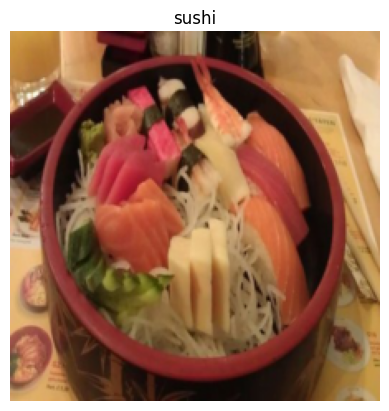

In [7]:
# Check dataloader
images, labels = next(iter(train_dataloader))
image = images[0]
label = labels[0]

class_names = ['pizza', 'steak', 'sushi']

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off");

# **== 3. Vision transformer (ViT) ==**
1. Path embedding : ```x_input = [class_token, image_path1, image_path2, image_path3 ...]``` each patch is learnable
2. Multi-head-attention : MSA wrapping LayerNorm layer(LN) -> (residual connection) :   
    ``` X_output_MSA_block =  MSA_layer((LN_layer(x_input))) + x_output ```
3. Multilayer-perceptron layer : MLP wrapping LayerNorm(LN) -< (residual connection) :   
    ``` x_output_MLP_block = MLP_layer(LN_layer(X_output_MSA_block)) + x_output ```
4. Output layer (y) :   
    ``` y = Linear_layer(LN_layer(x_output_MLP_block[0]))```

## 3.1 Equation 1 : Patch embedding
(`CLASS TOKEN EMBEDDING`, `PATCH EMBEDDING`) + `POSITION EMBEDDING`

### 3.1.1 Split data into patches
patch_embedding 期待的輸入為 H * W * C (2d圖高, 2d圖寬, 色彩通道)  
patch_embedding 期待的輸出為 N * (P*P * C) -> 1D sequence of flattened 2D patches

Split data into patches, explanation step by step

In [8]:
height = 224
width = 224
color_channel = 3
patch_size = 16

number_of_patchs = int(height * width) / patch_size ** 2
print(f"Number of patch with image height={height}, width={width} and patch_size={patch_size} -> {number_of_patchs}")

Number of patch with image height=224, width=224 and patch_size=16 -> 196.0


In [9]:
# Input shape
embedding_layer_input_shape = (height, width, color_channel)

# Output shape
embedding_layer_output_shape = (number_of_patchs, patch_size ** 2 * color_channel)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196.0, 768)


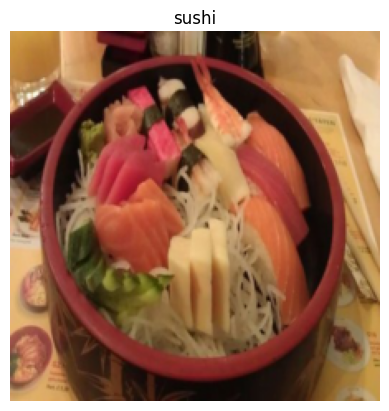

In [10]:
# Single image from train_dataset
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off");

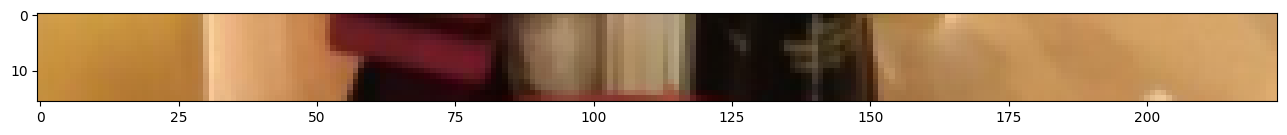

In [11]:
image_permuted = image.permute(1, 2, 0) # (height, width, color_channel)

#
patch_size = 16
plt.figure(figsize = (16, 16))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patch per row: 196.0,
Each patch's shape: (16 * 16)


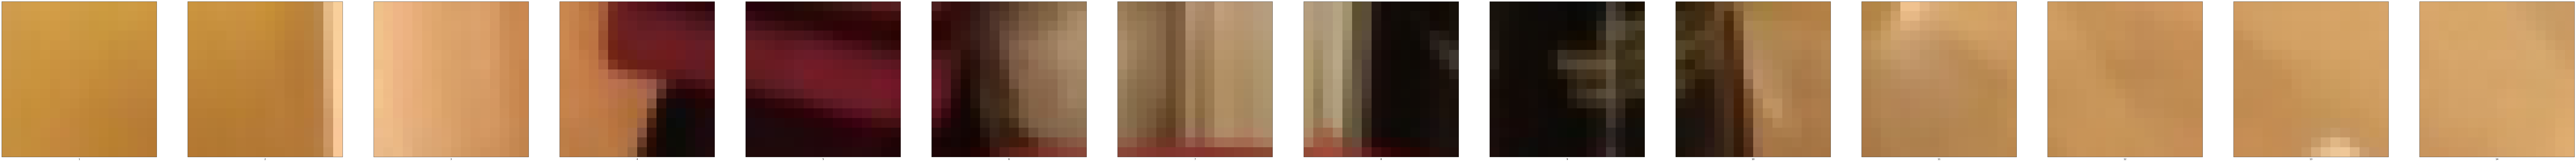

In [12]:
image_size = 224
patch_size = 16
assert image_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patch per row: {number_of_patchs},\nEach patch's shape: ({patch_size} * {patch_size})")

fig, axs = plt.subplots(nrows = 1,
                        ncols = image_size // patch_size,
                        figsize = (number_of_patchs, number_of_patchs),
                        sharex = True,
                        sharey = True)

for i, patch in enumerate(range(0, image_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


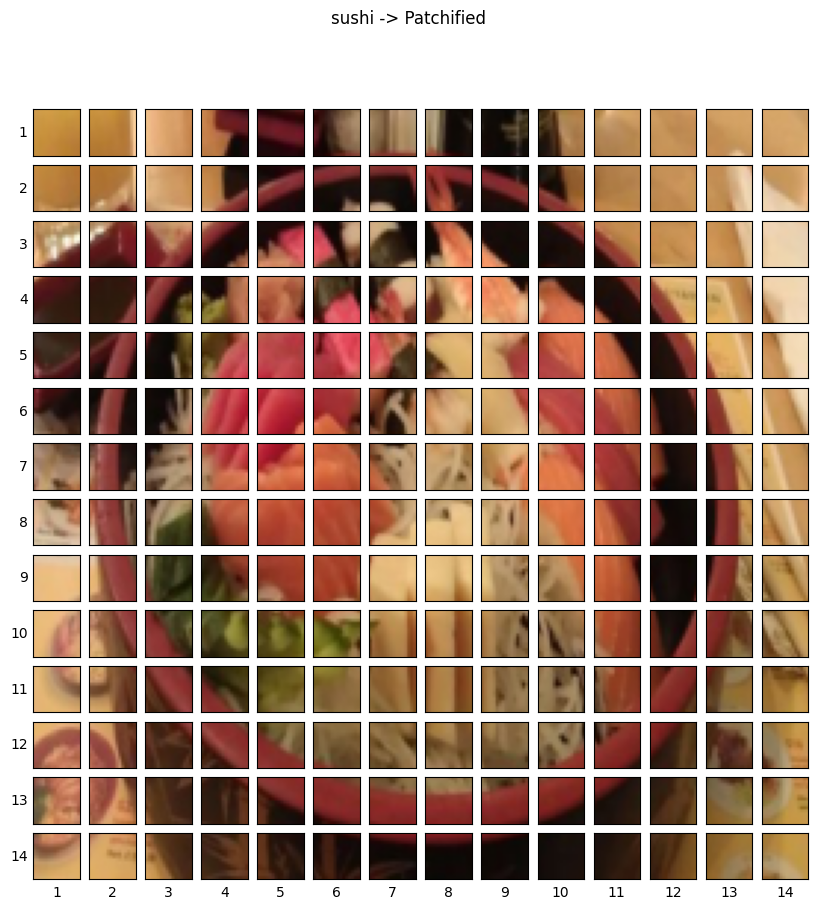

In [13]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Subplot
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(10, 10),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iter through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iter through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified")
plt.show()

Each patch through **`one kernel`**

In [14]:
# ViT-Base -> Layers: 12 / Hidden sizeD: 768 / MLP size: 3072 / Heads: 16 / params: 86 Million
from torch import nn

conv2d = nn.Conv2d(in_channels = 3,
                   out_channels = 768,
                   kernel_size = patch_size,
                   stride = patch_size, # 一個patch conv2d 後, 就移動到下一個patch
                   padding = 0)

In [15]:
image_out_of_conv2d = conv2d(image.unsqueeze(dim=0))
print(image_out_of_conv2d.shape)
# batch_size, embedding dimension, feature_map_height, feature_map_width   ->   每一個ptach 都變成 768特徵

torch.Size([1, 768, 14, 14])


Showing random features from indexs: [605, 569, 423, 410, 464]


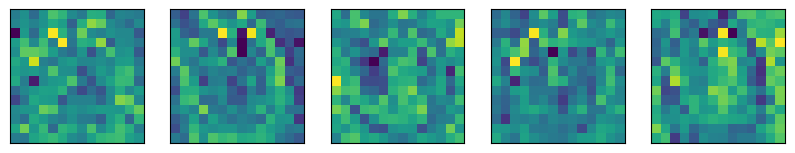

In [16]:
# 隨機從 768 中 挑 5 個特徵 檢視
import random

random_idx = random.sample(range(0, 768), k=5)
print(f"Showing random features from indexs: {random_idx}")

fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (10, 10))

for i, idx in enumerate(random_idx):
    image_in_768 = image_out_of_conv2d[:, idx, :, :]
    axs[i].imshow(image_in_768.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [17]:
# 整張圖: 經過conv2d(in=3, out=768) 由RGB三通道 -> 768通道
# 各通道: 經過 kernel_size=16*16 & stride 16 後, 變成 一個tensor 14 * 14
# Flatten: 768通道, 196

# nn.Flatten()
flatten = nn.Flatten(start_dim = 2, end_dim = 3) # 將index 從2開始到3 的維度一維化

#
image_out_of_conv2d_and_flatten = flatten(image_out_of_conv2d)

In [18]:
print(f"Original image shape: {image.shape}")
print(f"Image feature map shape: {image_out_of_conv2d.shape}")
print(f"Flatten image feature map shape: {image_out_of_conv2d_and_flatten.shape}")

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flatten image feature map shape: torch.Size([1, 768, 196])


In [19]:
# 使其符合指定輸出 shape
shaped_image_out_of_conv2d_and_flatten = image_out_of_conv2d_and_flatten.permute(0, 2, 1)
print(shaped_image_out_of_conv2d_and_flatten.shape)

# 從 768 種線性特徵中挑出其中一種
single_flattened_feature_map = shaped_image_out_of_conv2d_and_flatten[:, :, 0]

torch.Size([1, 196, 768])


In [20]:
"""
目前我們已經將一張 2維彩色圖片 轉換為: 1D learnable embedding vector
"""

'\n目前我們已經將一張 2維彩色圖片 轉換為: 1D learnable embedding vector\n'

### 3.1.2 Patch embedding layer to module
將 3.1.1 轉為 class

In [21]:
class PatchEmbedding(nn.Module):
    """
    Turns a 2D image into 1D sequence learnable embedding vector.

    Args:
        in_channels (int): 輸入圖像的色彩通道, default: 3
        patch_size (int): 每個 patch 大小, default: 16
        embedding_dim (int): embedding 嵌入向量的維度大小, default: 768
    """
    def __init__(self,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768):
        super().__init__()

        # This layer turn image into patches
        self.patcher = nn.Conv2d(in_channels = in_channels,
                                 out_channels = embedding_dim,
                                 kernel_size = patch_size,
                                 stride = patch_size,
                                 padding = 0)

        # This layer turn patches into 1D
        self.flatten = nn.Flatten(start_dim = 2,
                                  end_dim = 3)

    def forward(self ,x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Image size must be divisible by patch_size, input shape: {image_resolution}, patch_size: {patch_size}"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute(0, 2, 1)

In [22]:
image.size()

torch.Size([3, 224, 224])

In [23]:
# 測試 class PatchEmbedding -1

patchify = PatchEmbedding(in_channels = 3, patch_size = 16, embedding_dim = 768)

print(f"Image original size: {image.size()}")
print(f"Image unsqueeze size: {image.unsqueeze(dim = 0).size()} -> added batch size")

image_through_patch_embedded = patchify(image.unsqueeze(dim = 0))
print(f"Image through patch embedding layer size: {image_through_patch_embedded.size()}")

Image original size: torch.Size([3, 224, 224])
Image unsqueeze size: torch.Size([1, 3, 224, 224]) -> added batch size
Image through patch embedding layer size: torch.Size([1, 196, 768])


In [24]:
# 測試 class PatchEmbedding -2

random_input_image_correct = (1, 3, 224, 224)
random_input_image_error = (1, 3, 225, 225)

summary(patchify,
        input_size = random_input_image_correct,
        col_names = ["output_size", "num_params", "trainable"],
        col_width = 17)

Layer (type:depth-idx)                   Output Shape      Param #           Trainable
PatchEmbedding                           [1, 196, 768]     --                True
├─Conv2d: 1-1                            [1, 768, 14, 14]  590,592           True
├─Flatten: 1-2                           [1, 768, 196]     --                --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### 3.1.3 Creating class token embedding

In [25]:
print(image_through_patch_embedded)
print(f"Patch embedding size: {image_through_patch_embedded.size()} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.1011, -0.1965, -0.0995,  ..., -0.2209,  0.0276, -0.2011],
         [-0.1542, -0.2901, -0.1329,  ..., -0.2455,  0.0263, -0.1865],
         [-0.2013, -0.1660, -0.0779,  ..., -0.3101,  0.0088, -0.3221],
         ...,
         [-0.0776, -0.1262, -0.1031,  ..., -0.1244,  0.0132, -0.0809],
         [-0.1413, -0.1849, -0.0693,  ..., -0.2176,  0.0077, -0.1731],
         [-0.2256, -0.2211, -0.0977,  ..., -0.2902,  0.0051, -0.2283]]],
       grad_fn=<PermuteBackward0>)
Patch embedding size: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [26]:
# class token
# torch.ones -> 僅為了測試 class token / 實際場景 需要使用 torch.randn()

batch_size = image_through_patch_embedded.shape[0]
embedding_dimension = image_through_patch_embedded.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad = True)

print(f"class_token 1-10 elements: {class_token[:, :, :10]}\n"
      f"class_token's size: {class_token.size()}")

class_token 1-10 elements: tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
class_token's size: torch.Size([1, 1, 768])


In [27]:
patch_embedding_with_class_embedding = torch.cat((class_token, image_through_patch_embedded),
                                                 dim = 1)

print(patch_embedding_with_class_embedding)

print(f"\nBefore prepended:\n{image_through_patch_embedded.size()}\n")
print(f"After class_token prepended to patch_embedding:\n{patch_embedding_with_class_embedding.size()}")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.1011, -0.1965, -0.0995,  ..., -0.2209,  0.0276, -0.2011],
         [-0.1542, -0.2901, -0.1329,  ..., -0.2455,  0.0263, -0.1865],
         ...,
         [-0.0776, -0.1262, -0.1031,  ..., -0.1244,  0.0132, -0.0809],
         [-0.1413, -0.1849, -0.0693,  ..., -0.2176,  0.0077, -0.1731],
         [-0.2256, -0.2211, -0.0977,  ..., -0.2902,  0.0051, -0.2283]]],
       grad_fn=<CatBackward0>)

Before prepended:
torch.Size([1, 196, 768])

After class_token prepended to patch_embedding:
torch.Size([1, 197, 768])


### 3.1.4 Creating position embedding

In [28]:
# 示範時用 torch.ones 創造 position embedding -> 真實場景 需要使用 torch.randn()

# Number of patches
number_of_patches = int((height * width) / (patch_size * patch_size))

# Get embedding dimension
latest_embedding_dimension = patch_embedding_with_class_embedding.shape[2]

# Create learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches + 1,
                                             latest_embedding_dimension,
                                             requires_grad = True))

print(f"First 10 sequence and 10 position embedding:\n{position_embedding[:, :10, :10]}")
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

First 10 sequence and 10 position embedding:
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [29]:
# "Add" position embedding to patch_and_class_token_embedding
patch_and_position_embedding = patch_embedding_with_class_embedding + position_embedding

print(patch_and_position_embedding)
print(f"\nClass token embedding (prepended)\nPatch embedding\n'Add' position embedding\n{patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.8989, 0.8035, 0.9005,  ..., 0.7791, 1.0276, 0.7989],
         [0.8458, 0.7099, 0.8671,  ..., 0.7545, 1.0263, 0.8135],
         ...,
         [0.9224, 0.8738, 0.8969,  ..., 0.8756, 1.0132, 0.9191],
         [0.8587, 0.8151, 0.9307,  ..., 0.7824, 1.0077, 0.8269],
         [0.7744, 0.7789, 0.9023,  ..., 0.7098, 1.0051, 0.7717]]],
       grad_fn=<AddBackward0>)

Class token embedding (prepended)
Patch embedding
'Add' position embedding
torch.Size([1, 197, 768])


### 3.1.5 Equation 1 sum up & recap

1. Setting patch size (ViT base - 16)
2. Check input image's height & width
3. Add a batch dimension for `patch embedding` (patch_size = 16, embedding_dim = 768)
4. Create `class token embedding`
5. **_Prepended_** `class token embedding`
6. Create `position embedding`
7. **_Adding_** `position embedding` to `class token and patch embedding`

In [30]:
# 參數
PATCH_SIZE = 16
EMBEDDING_DIM = 768

# 紀錄 : 圖像高, 寬
print(f"Original image -> shape: {image.shape}")
image_height, image_width = image.shape[1], image.shape[2]

# Add batch size
X = image.unsqueeze(dim = 0)
print(f"Image add batch size -> shape: {X.shape}")

# Use patch embedding function
patch_embedding_layer =  PatchEmbedding(in_channels = 3, patch_size = PATCH_SIZE, embedding_dim = EMBEDDING_DIM)

# Image through patch embedding layer
X_patch_embedding = patch_embedding_layer(X)
print(f"Image after patch embedding -> shape: {X_patch_embedding.shape}")

# Create class token embedding
batch_size = X_patch_embedding.shape[0]
embedding_dimension = X_patch_embedding.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad = True)
print(f"\nClass token embedding -> shape: {class_token.shape}")

# Prepended class token embedding
patch_embedding_class_token = torch.cat((class_token, X_patch_embedding), dim = 1)
print(f"Class token prepended -> shape: {patch_embedding_class_token.shape}")

# Create position embedding
number_of_patches = int((image_height * image_width) / (PATCH_SIZE * PATCH_SIZE))
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad = True)

# "Add" position embedding to patch_embedding_with_class_token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"\nPatch and position embedding -> shape: {patch_and_position_embedding.shape}")

Original image -> shape: torch.Size([3, 224, 224])
Image add batch size -> shape: torch.Size([1, 3, 224, 224])
Image after patch embedding -> shape: torch.Size([1, 196, 768])

Class token embedding -> shape: torch.Size([1, 1, 768])
Class token prepended -> shape: torch.Size([1, 197, 768])

Patch and position embedding -> shape: torch.Size([1, 197, 768])


## 3.2 Equation 2 : Multi-Head attention
* Normalization (Layer Normalization, LN) -> 對每個位置的特徵標準化
* Multi-Head attention -> 計算注意力權重, 將序列中不同位置關聯起來, 判斷: 圖片相依性 or 上下文關係
* Residual connection -> 殘差連接: `輸入multi-head attention前` + `輸入multi-head attention後`, 舒緩梯度消失問題

In [31]:
# Patch embedding 最後輸出
print(f"\nPatch and position embedding -> shape: {patch_and_position_embedding.shape}")


Patch and position embedding -> shape: torch.Size([1, 197, 768])


In [32]:
# MSA block (尚未添加殘差層)

class MSA(nn.Module):
    """Multi-head self-attention block"""
    def __init__(self,
                 embedding_dim: int = 768,
                 num_heads: int = 12,
                 attn_dropout: float = 0):
        super().__init__()

        self.ln = nn.LayerNorm(normalized_shape = embedding_dim)

        self.msa = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                    num_heads = num_heads,
                                                    dropout = attn_dropout,
                                                    batch_first = True)

    def forward(self, x):
        x = self.ln(x)
        attn_output, _ = self.msa(query = x,
                                  key = x,
                                  value = x,
                                  need_weights = False)
        return attn_output

## 3.3 Equation 3: Multilayer Perceptron

In [33]:
# Patch embedding 最後輸出
print(f"\nPatch and position embedding -> shape: {patch_and_position_embedding.shape}")


Patch and position embedding -> shape: torch.Size([1, 197, 768])


In [34]:
# MLP block (尚未添加殘差層)

class MLP(nn.Module):
    def __init__(self,
                 embedding_dim: int = 768,
                 mlp_size: int = 3072, # mlp size from Table1 for ViT base
                 dropout: float = 0.1):
        super().__init__()

        self.ln = nn.LayerNorm(normalized_shape = embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features = embedding_dim, out_features = mlp_size),
            nn.GELU(),
            nn.Dropout(p = dropout),
            nn.Linear(in_features = mlp_size, out_features = embedding_dim),
            nn.Dropout(p = dropout)
        )

    def forward(self, x):
        x = self.ln(x)
        x = self.mlp(x)

        return x

## 3.4 Transformer **`Encoder`**

### 3.4.1 Class by ourselves

In [35]:
class Encoder_by_ourselves(nn.Module):
    """Create a Transformer Encoder block"""
    def __init__(self,
                 embedding_dim: int = 768,
                 num_heads: int = 12,
                 mlp_size: int = 3072,
                 attn_dropout: float = 0,
                 mlp_dropout: float = 0.1):
        super().__init__()

        # MSA block
        self.msa_block = MSA(embedding_dim = 768, num_heads = 12, attn_dropout = 0)

        # MLP block
        self.mlp_block = MLP(embedding_dim = 768, mlp_size = 3072, dropout = 0.1)

    def forward(self, x):
        # Residual connection for MSA
        x = self.msa_block(x) + x

        # Residual connection for MLP
        x = self.mlp_block(x) + x

        return x

In [36]:
transformer_encoder_block = Encoder_by_ourselves()

summary(model = transformer_encoder_block,
        input_size = (1, 197, 768), # [batch_size, num_patches, embedding_dim]
        col_names = ["output_size", "num_params", "trainable"],
        col_width = 18)

Layer (type:depth-idx)                   Output Shape       Param #            Trainable
Encoder_by_ourselves                     [1, 197, 768]      --                 True
├─MSA: 1-1                               [1, 197, 768]      --                 True
│    └─LayerNorm: 2-1                    [1, 197, 768]      1,536              True
│    └─MultiheadAttention: 2-2           [1, 197, 768]      2,362,368          True
├─MLP: 1-2                               [1, 197, 768]      --                 True
│    └─LayerNorm: 2-3                    [1, 197, 768]      1,536              True
│    └─Sequential: 2-4                   [1, 197, 768]      --                 True
│    │    └─Linear: 3-1                  [1, 197, 3072]     2,362,368          True
│    │    └─GELU: 3-2                    [1, 197, 3072]     --                 --
│    │    └─Dropout: 3-3                 [1, 197, 3072]     --                 --
│    │    └─Linear: 3-4                  [1, 197, 768]      2,360,064      

### 3.4.2 PyTorch buildin: EncoderLayer -> Encoder

In [37]:
torch_transformer_encoder = nn.TransformerEncoderLayer(d_model = 768,         # Hidden size D
                                                       nhead = 12,            # Heads
                                                       dim_feedforward=3072,  # MLP size
                                                       dropout = 0.1,         # MLP dropout
                                                       activation = "gelu",   #
                                                       batch_first = True,    # batch comes first?
                                                       norm_first = True)     # normalize before MSA, MLP

print(torch_transformer_encoder)

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)


In [38]:
torch_transformer_encoder_blocks = nn.TransformerEncoder(encoder_layer = torch.nn.TransformerEncoderLayer(d_model = 768, nhead=12),
                                                         num_layers = 2)
torch_transformer_encoder_blocks

TransformerEncoder(
  (layers): ModuleList(
    (0-1): 2 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)

## 3.5 Equation 4: MLP head (Output layer)
torch.nn.LayerNorm(), torch.nn.Linear()

# **== 4. Build ViT ==**

### 4.1 ViT structure and build

In [39]:
class ViT(nn.Module):
    """Creates a vision transformer based on ViT-Base"""
    def __init__(self,
                 image_size:int = 224,
                 in_channels:int = 3,
                 patch_size:int = 16,
                 num_transformer_layers:int = 12,
                 embedding_dims:int = 768,
                 mlp_size:int = 3072,
                 num_heads:int = 12,
                 attn_dropout:float = 0,
                 mlp_dropout:float = 0.1,
                 embedding_dropout:float = 0.1,
                 num_classes:int = 1000): # default from ImageNet, but this can customize
        super().__init__()

        assert image_size % patch_size == 0, f"Image_size can not divide by patch_size: image_size {image_size} / patch_size {patch_size}"

        self.num_patches = (image_size * image_size) // (patch_size * patch_size)

        self.class_embedding = nn.Parameter(data = torch.randn(1, 1, embedding_dims),
                                            requires_grad = True)

        self.position_embedding = nn.Parameter(data = torch.randn(1, self.num_patches+1, embedding_dims),
                                               requires_grad = True)

        self.embedding_dropout = nn.Dropout(p = embedding_dropout)

        self.patch_embedding = PatchEmbedding(in_channels = in_channels,
                                              patch_size = patch_size,
                                              embedding_dim = embedding_dims)

        self.transformer_encoder = nn.Sequential(*[Encoder_by_ourselves(embedding_dim = embedding_dims,
                                                                        num_heads = num_heads,
                                                                        mlp_size = mlp_size,
                                                                        mlp_dropout = mlp_dropout) for _ in range(num_transformer_layers)])

        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape = embedding_dims),
                                        nn.Linear(in_features = embedding_dims, out_features = num_classes))

    def forward(self, x):
        batch_size = x.shape[0]

        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = self.patch_embedding(x)

        x = torch.cat((class_token, x), dim = 1)

        x = self.position_embedding + x

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0])

        return x

model_1 = ViT(num_classes = len(class_names))

In [40]:
# Example of creating class embedding and expanding over batch dimension
batch_size = 32

class_token_embedding_single = nn.Parameter(data = torch.randn(1, 1, 768))
class_token_embedding_expand = class_token_embedding_single.expand(batch_size, -1, -1) # -1 將維持原值

print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expand.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


### 4.2 Test model_1 (ViT)

In [41]:
# Test ViT

class_names = ["pizza", "steak", "sushi"]

random_image_tensor = torch.randn(1, 3, 224, 224)

logits = model_1(random_image_tensor)
logits

tensor([[ 0.2372, -0.9336,  1.0144]], grad_fn=<AddmmBackward0>)

### 4.3 Model_1 info.

In [42]:
summary(model = model_1,
        input_size = (32, 3, 224, 224),
        col_names = ["output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                       Output Shape         Param #              Trainable
ViT (ViT)                                     [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)            [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                       [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                      [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                 [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)            [32, 197, 768]       --                   True
│    └─Encoder_by_ourselves (0)               [32, 197, 768]       --                   True
│    │    └─MSA (msa_block)                   [32, 197, 768]       2,363,904            True
│    │    └─MLP (mlp_block)                   [32, 197, 768]       4,723,968            True
│    └─Encoder_by_ourselves (1)               [32, 197, 768]       --

# **== 5. Func: train, test, train_test_loop ==**

In [43]:
# Func: train -> train_loss, train_acc
def train(model, dataloader, loss_fn, optimizer, device):
    model.to(device)
    model.train()

    train_loss, train_acc = 0.0, 0.0

    for batch, (X_train, y_train) in enumerate(dataloader):
        # Data to device
        X_train, y_train = X_train.to(device), y_train.to(device)
        # Forward pass
        # Logits
        train_preds = model(X_train)
        # Calculate the loss
        loss = loss_fn(train_preds, y_train)
        train_loss = train_loss + loss.item()

        # Back forward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate the acc
        train_preds_label = torch.argmax(torch.softmax(train_preds, dim = 1), dim = 1)
        train_acc = train_acc + (train_preds_label == y_train).sum().item() / len(train_preds)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [44]:
# Func: test -> test_loss, test_acc

def test(model, dataloader, loss_fn, device):
    model.to(device)
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X_test, y_test) in enumerate(dataloader):
            # Data to device
            X_test, y_test = X_test.to(device), y_test.to(device)
            # Forward pass
            # Logits
            test_preds = model(X_test)
            # Calculate the loss
            loss = loss_fn(test_preds, y_test)
            test_loss = test_loss + loss.item()

            # Calculate the acc
            test_preds_label = torch.argmax(torch.softmax(test_preds, dim = 1), dim = 1)
            test_acc = test_acc + (test_preds_label == y_test).sum().item() / len(test_preds)

        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)

        return test_loss, test_acc

In [51]:
# Func: train_test_loop - dict{"train_loss":[], "train_acc":[], "test_loss":[], "test_acc":[]}

def train_test_loop(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs, device):
    model.to(device)

    results = {"train_loss":[], "train_acc":[], "test_loss":[], "test_acc":[]}

    for epoch in range(epochs):
        # Train
        train_loss, train_acc = train(model = model,
                                      dataloader = train_dataloader,
                                      loss_fn = loss_fn,
                                      optimizer = optimizer,
                                      device = device)
        # Test
        test_loss, test_acc = test(model = model,
                                   dataloader = test_dataloader,
                                   loss_fn = loss_fn,
                                   device = device)
        # Progress
        print(f"Epoch: {epoch+1}\n"
              f"Train Loss: {train_loss:.4f} | Train Accuracy: {(train_acc*100):.3f}%\n"
              f"Test Loss: {test_loss:.4f} | Test Accuracy: {(test_acc*100):.3f}%"
              )
        # Append results dict
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

# **== 6. Train model_1 (made by ourselves) ==**

In [52]:
# Train

device = "cuda" if torch.cuda.is_available() else "cpu"

# Vision_transformer's paper did not specify the loss_fn
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = model_1.parameters(),
                             lr = 0.003, # Table-3 for ViT-* ImageNet-1k
                             weight_decay = 0.3) # Table 3 for ViT-* ImageNet-1k

results_1 = train_test_loop(model = model_1,
                            train_dataloader = train_dataloader,
                            test_dataloader = test_dataloader,
                            loss_fn = loss_fn,
                            optimizer = optimizer,
                            epochs = 10,
                            device = device)


Epoch: 1
Train Loss: 1.6121 | Train Accuracy: 33.929%
Test Loss: 1.1491 | Test Accuracy: 39.062%
Epoch: 2
Train Loss: 1.4991 | Train Accuracy: 31.250%
Test Loss: 1.1005 | Test Accuracy: 31.250%
Epoch: 3
Train Loss: 1.2227 | Train Accuracy: 29.911%
Test Loss: 1.0923 | Test Accuracy: 39.062%
Epoch: 4
Train Loss: 1.1245 | Train Accuracy: 30.804%
Test Loss: 1.0950 | Test Accuracy: 39.062%
Epoch: 5
Train Loss: 1.1284 | Train Accuracy: 32.589%
Test Loss: 1.1057 | Test Accuracy: 29.688%
Epoch: 6
Train Loss: 1.1210 | Train Accuracy: 29.464%
Test Loss: 1.0966 | Test Accuracy: 39.062%
Epoch: 7
Train Loss: 1.1050 | Train Accuracy: 30.804%
Test Loss: 1.1109 | Test Accuracy: 29.688%
Epoch: 8
Train Loss: 1.1280 | Train Accuracy: 33.036%
Test Loss: 1.1109 | Test Accuracy: 39.062%
Epoch: 9
Train Loss: 1.1478 | Train Accuracy: 27.679%
Test Loss: 1.1605 | Test Accuracy: 29.688%
Epoch: 10
Train Loss: 1.1649 | Train Accuracy: 29.911%
Test Loss: 1.1091 | Test Accuracy: 39.062%


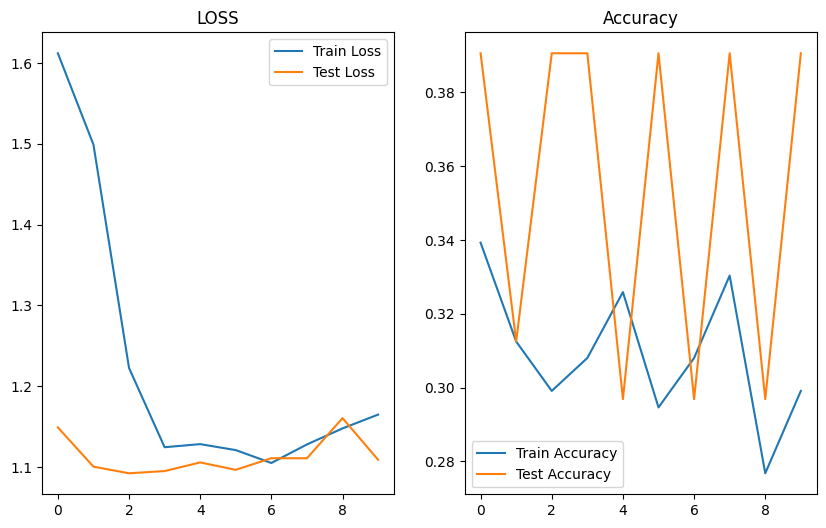

In [53]:
# Visual
plt.figure(figsize = (10, 6))

plt.subplot(1, 2, 1)
plt.plot(results_1["train_loss"], label = "Train Loss")
plt.plot(results_1["test_loss"], label = "Test Loss")
plt.title("LOSS")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results_1["train_acc"], label = "Train Accuracy")
plt.plot(results_1["test_acc"], label = "Test Accuracy")
plt.title("Accuracy")
plt.legend()


In [ ]:
# 模型效果不好！！！

# **== 7. Train model_2 (torchvision.models) ==**

## 7.1 Transfer and adjust

In [54]:
# Download model's weights

device = "cuda" if torch.cuda.is_available() else "cpu"

pretrained_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

model_2 = torchvision.models.vit_b_16(weights = pretrained_weights).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 65.1MB/s]


In [55]:
# Freeze model's weight
for param in model_2.parameters():
    param.requires_grad = False

In [58]:
# 更改最後輸出層，以符合我方目的

model_2.heads = nn.Sequential(
    nn.Linear(in_features = 768, out_features = 128),
    nn.ReLU(),
    nn.Dropout(p = 0.2),
    nn.Linear(in_features = 128, out_features = 32),
    nn.ReLU(),
    nn.Dropout(p = 0.1),
    nn.Linear(in_features = 32, out_features = 3)
).to(device)

model_2.heads

Sequential(
  (0): Linear(in_features=768, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=128, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=32, out_features=3, bias=True)
)

## 7.2 Model_2 info.

In [59]:
summary(model = model_2,
        input_size = (32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 768]       (7,087,872)          False
│    │    └─Enco

## 7.3 Prepare dataloader

In [60]:
 # Check path
 train_dir, test_dir

(PosixPath('data/db_image_data/train'), PosixPath('data/db_image_data/test'))

In [63]:
# Transform
model_2_transform = pretrained_weights.transforms()

In [64]:
# dataset
train_dataset = datasets.ImageFolder(root = train_dir, transform = model_2_transform)
test_dataset = datasets.ImageFolder(root = test_dir, transform = model_2_transform)

In [65]:
# dataloader
train_dataloader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True, drop_last = True)
test_dataloader = DataLoader(dataset = test_dataset, batch_size = 32, shuffle = False, drop_last = True)

## 7.4 Train model_2

In [66]:
device = "cuda" if torch.cuda.is_available() else "cpu"

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_2.parameters(),
                             lr = 0.003,
                             weight_decay = 0.3)

results_2 = train_test_loop(model = model_2,
                            train_dataloader = train_dataloader,
                            test_dataloader = test_dataloader,
                            loss_fn = loss_fn,
                            optimizer = optimizer,
                            epochs = 10,
                            device = device)

Epoch: 1
Train Loss: 0.9958 | Train Accuracy: 67.411%
Test Loss: 0.7887 | Test Accuracy: 92.188%
Epoch: 2
Train Loss: 0.7075 | Train Accuracy: 92.411%
Test Loss: 0.4975 | Test Accuracy: 92.188%
Epoch: 3
Train Loss: 0.4633 | Train Accuracy: 95.982%
Test Loss: 0.3205 | Test Accuracy: 95.312%
Epoch: 4
Train Loss: 0.3274 | Train Accuracy: 95.982%
Test Loss: 0.2953 | Test Accuracy: 92.188%
Epoch: 5
Train Loss: 0.3017 | Train Accuracy: 95.982%
Test Loss: 0.2737 | Test Accuracy: 92.188%
Epoch: 6
Train Loss: 0.2755 | Train Accuracy: 97.768%
Test Loss: 0.2452 | Test Accuracy: 96.875%
Epoch: 7
Train Loss: 0.2762 | Train Accuracy: 95.536%
Test Loss: 0.2576 | Test Accuracy: 96.875%
Epoch: 8
Train Loss: 0.2838 | Train Accuracy: 95.536%
Test Loss: 0.2580 | Test Accuracy: 92.188%
Epoch: 9
Train Loss: 0.2544 | Train Accuracy: 97.768%
Test Loss: 0.2507 | Test Accuracy: 98.438%
Epoch: 10
Train Loss: 0.2748 | Train Accuracy: 95.536%
Test Loss: 0.2603 | Test Accuracy: 95.312%


# **== 8. Compare model_1 and model_2 ==**

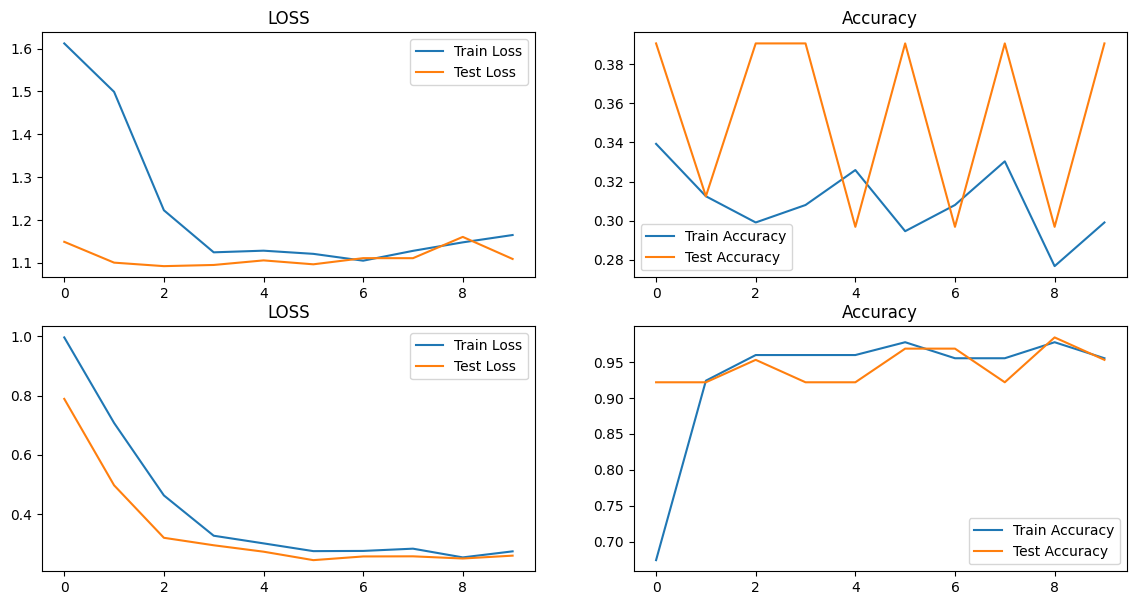

In [67]:
plt.figure(figsize = (14, 7))

plt.subplot(2, 2, 1)
plt.plot(results_1["train_loss"], label = "Train Loss")
plt.plot(results_1["test_loss"], label = "Test Loss")
plt.title("LOSS")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(results_1["train_acc"], label = "Train Accuracy")
plt.plot(results_1["test_acc"], label = "Test Accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(results_2["train_loss"], label = "Train Loss")
plt.plot(results_2["test_loss"], label = "Test Loss")
plt.title("LOSS")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(results_2["train_acc"], label = "Train Accuracy")
plt.plot(results_2["test_acc"], label = "Test Accuracy")
plt.title("Accuracy")
plt.legend()

# **== 9. Make predict ==**

In [88]:
# Func: pred_and_plot_image
from typing import List, Tuple
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device):
    # Open image
    img = Image.open(image_path)

    # transform
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    # Predict
    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim = 0)

        image_pred = model(transformed_image.to(device))

    image_pred_prob = torch.softmax(image_pred, dim = 1)
    image_pred_label = torch.argmax(image_pred_prob, dim = 1)

    # Plt image
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[image_pred_label]} | Prob: {(image_pred_prob.max()*100):.2f}%")
    plt.axis("off");

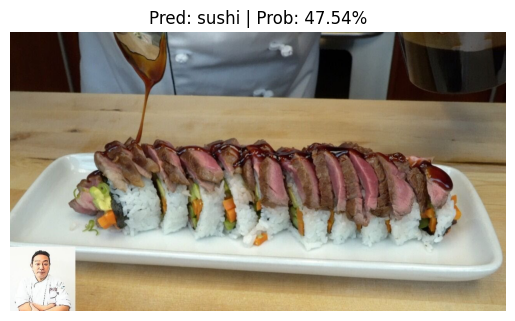

In [90]:
pred_and_plot_image(model = model_2,
                    image_path = "/content/test_img2.jpg",
                    class_names = ['pizza', 'steak', 'sushi'])